# Energy Demand Forecasting Using LSTM
Objective: Build and evaluate an LSTM model to forecast energy demand based on historical power usage data.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow as tf




# feature engineering 

In [2]:
df = pd.read_excel("archive/train_dataframes.xlsx")
df_test = pd.read_excel("archive/test_dataframes.xlsx")


df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df['month'] = df.index.month

#lags
lag_1, lag_24, lag_168 = [], [], []
df['lag_1'] = df['DEMAND'].shift(1)
df['lag_24'] = df['DEMAND'].shift(24)
df['lag_168'] = df['DEMAND'].shift(168)

# mean and std
df['roll_mean_6h']   = df['DEMAND'].rolling(window=6).mean()
df['roll_std_6h']    = df['DEMAND'].rolling(window=6).std()  #volatility
df['roll_mean_24h']  = df['DEMAND'].rolling(window=24).mean()
df['roll_std_24h']   = df['DEMAND'].rolling(window=24).std()
df['roll_mean_168h'] = df['DEMAND'].rolling(window=168).mean()
df['roll_std_168h']  = df['DEMAND'].rolling(window=168).std()

df.dropna(inplace=True)

# circle encoding bc 23 hr might seem farther than 0 but they are only 1 hr apart. model learns that end of cycle connects to start 
# Hour of day
df['hour_sin'] = np.sin(2 * np.pi * df['hourOfDay'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hourOfDay']/ 24)

# Month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Day of week
df['day_sin'] = np.sin(2 * np.pi * df['dayOfWeek'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['dayOfWeek'] / 7)



data = df[['hour_sin', 'hour_cos','day_sin','day_cos', 
           'week_X-2', 'week_X-3', 'week_X-4',
           'MA_X-4', 'weekend', 'Holiday_ID',
           'T2M_toc', 'month_sin','month_cos', 'DEMAND']].copy()

training_data_len = int(np.ceil(len(data)*0.95))









# Data Scaling Setup 
Imports RobustScaler for outlier-resistant normalization.

In [3]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaled_data = scaler.fit_transform(data)


# Creating sliding-window 
in order to use past week data to predict demand 

In [4]:
# LSTM model(predicts one step)
seq_len = 168
X_train, Y_train = [],[]
for i in range(168, len(scaled_data)):
    X_train.append(scaled_data[i-seq_len:i])
    Y_train.append(scaled_data[i,-1])
X_train = np.array(X_train) #(samples,168,5)
Y_train = np.array(Y_train)
X_train.shape , Y_train.shape
    

((36384, 168, 14), (36384,))

# LSTM Model Definition 
Builds a sequential LSTM network that predicts only next hour demand

In [5]:
model = keras.models.Sequential()
# 1st layer
model.add(keras.layers.LSTM(64, return_sequences = True, input_shape = (168,14)))
# 2nd layer
model.add(keras.layers.LSTM(64, return_sequences = False))
# 3rd layer
model.add(keras.layers.Dense(32, activation = "relu"))
# 4th layer
model.add(keras.layers.Dropout(0.5))
# final layer
model.add(keras.layers.Dense(1))

model.summary()
model.compile(optimizer = "adam",
            loss ="mse",   #mae treats all points equally
            metrics = [keras.metrics.RootMeanSquaredError()])

from sklearn.model_selection import train_test_split
X_train_lstm, X_val_lstm, Y_train_lstm, Y_val_lstm = train_test_split(
    X_train, Y_train, test_size=0.2, shuffle=False
)

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


training = model.fit(
    X_train_lstm, Y_train_lstm,
    epochs=100,  
    batch_size=128,
    validation_data=(X_val_lstm, Y_val_lstm),
    callbacks=[early_stopping],
    verbose=1
)
    


2025-08-09 18:19:04.019729: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-08-09 18:19:04.019771: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-08-09 18:19:04.019778: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-08-09 18:19:04.019801: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-09 18:19:04.019817: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 168, 64)        │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,361 (216.25 KB)

 Trainable params: 55,361 (216.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


2025-08-09 18:19:05.106230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-08-09 18:19:05.110083: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


228/228 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - loss: 0.1267 - root_mean_squared_error: 0.3465 - val_loss: 0.0346 - val_root_mean_squared_error: 0.1861
Epoch 2/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - loss: 0.0432 - root_mean_squared_error: 0.2078 - val_loss: 0.0212 - val_root_mean_squared_error: 0.1454
Epoch 3/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - loss: 0.0375 - root_mean_squared_error: 0.1936 - val_loss: 0.0180 - val_root_mean_squared_error: 0.1342
Epoch 4/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.0373 - root_mean_squared_error: 0.1930 - val_loss: 0.0163 - val_root_mean_squared_error: 0.1275
Epoch 5/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 0.0338 - root_mean_squared_error: 0.1837 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1168
Epoch 6/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.0327 - root_mean_squared_error: 0.1809 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1056
Epoch 7/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 11s 4

# Testing and Plotting 

 4/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step  

2025-08-09 18:24:04.507847: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step


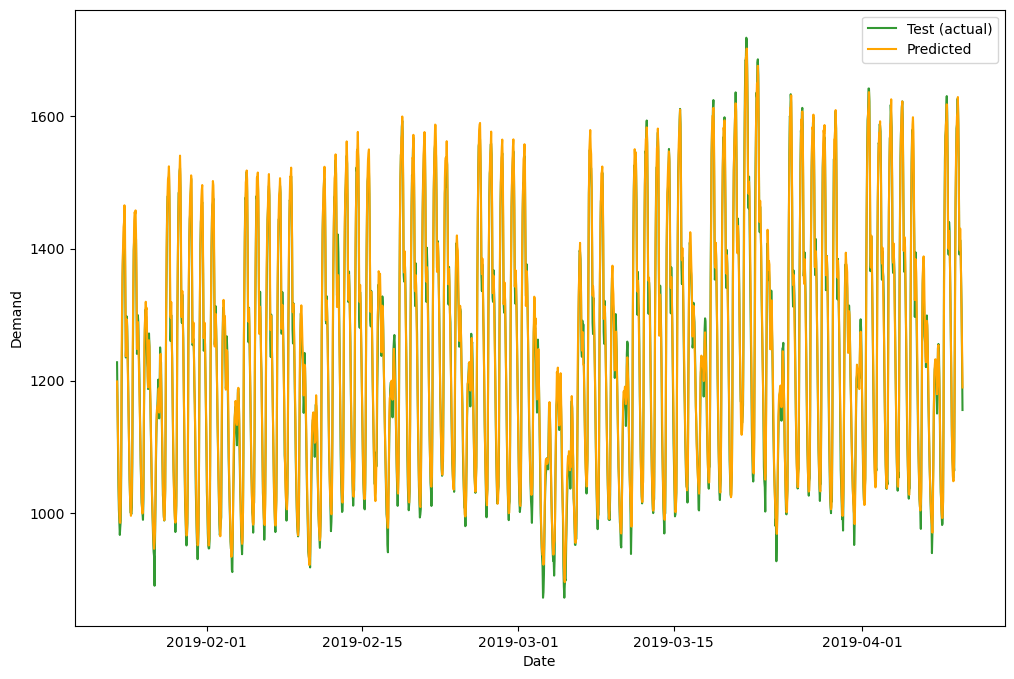

📊 MAPE = 1.21%


In [6]:
#Prep test data

test_data = scaled_data[training_data_len - seq_len:]
X_test, Y_test = [], []

for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i - seq_len:i])
    Y_test.append(test_data[i, -1])

X_test = np.array(X_test)
Y_test = np.array(Y_test)


predictions_scaled = model.predict(X_test)


Y_test_full = np.zeros((len(Y_test), scaled_data.shape[1]))
pred_full = np.zeros((len(predictions_scaled), scaled_data.shape[1]))

Y_test_full[:, -1] = Y_test
pred_full[:, -1] = predictions_scaled[:, 0]


Y_test_original = scaler.inverse_transform(Y_test_full)[:, -1]
predicted_demand = scaler.inverse_transform(pred_full)[:, -1]


#Plotting
train = data[:training_data_len]
test = data[training_data_len:]
test = test.copy()
test['Predictions'] = predicted_demand

plt.figure(figsize=(12, 8))

plt.plot(test.index, test['DEMAND'], label='Test (actual)', color='green', alpha=0.8)
plt.plot(test.index, test['Predictions'], label='Predicted', color='orange')
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend()
plt.show()

mape = np.mean(np.abs((Y_test_original - predicted_demand) / Y_test_original)) * 100
print(f"📊 MAPE = {mape:.2f}%")

# using SEQ2SEQ model to predict next 24 hour demand at once

# sliding-window

In [7]:
# Seq2Seq model

xtrain_s2s ,ytrain_s2s= [],[]
predict_len = 28
seq_len = 168
for t in range(seq_len,len(scaled_data) - predict_len):
    xtrain_s2s.append(scaled_data[t-seq_len:t])
    ytrain_s2s.append(scaled_data[t:t + predict_len, -1])

xtrain_s2s, ytrain_s2s = np.array(xtrain_s2s), np.array(ytrain_s2s)
xtrain_s2s.shape, ytrain_s2s.shape





((36356, 168, 14), (36356, 28))

# Seq2Seq Model Setup.

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed


ytrain_s2s = ytrain_s2s.reshape(ytrain_s2s.shape[0], ytrain_s2s.shape[1], 1) # seq2seq expects 3D shape


input_len = xtrain_s2s.shape[1]
num_features = xtrain_s2s.shape[2]
output_len = ytrain_s2s.shape[1]


# Define the model
model_s2s = Sequential()

#Encoder
model_s2s.add(LSTM(64,  input_shape=(input_len, num_features)))

#Bridge 
model_s2s.add(RepeatVector(output_len))

#Decoder
model_s2s.add(LSTM(64,  return_sequences=True))

# Final Output Layer 
model_s2s.add(TimeDistributed(Dense(1)))



model_s2s.compile(optimizer='adam', loss='mse')
model_s2s.summary()

from sklearn.model_selection import train_test_split
X_train_s2s, X_val_s2s, Y_train_s2s, Y_val_s2s = train_test_split(
    xtrain_s2s, ytrain_s2s, test_size=0.2, shuffle=False
)

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


training = model_s2s.fit(
    X_train_s2s, Y_train_s2s,
    epochs=100,  
    batch_size=128,
    validation_data=(X_val_s2s, Y_val_s2s),
    callbacks=[early_stopping],
    verbose=1
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 28, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 28, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 28, 1)          │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,313 (208.25 KB)

 Trainable params: 53,313 (208.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - loss: 0.1998 - val_loss: 0.0466
Epoch 2/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - loss: 0.0366 - val_loss: 0.0393
Epoch 3/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - loss: 0.0298 - val_loss: 0.0334
Epoch 4/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - loss: 0.0252 - val_loss: 0.0316
Epoch 5/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - loss: 0.0224 - val_loss: 0.0301
Epoch 6/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - loss: 0.0215 - val_loss: 0.0302
Epoch 7/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - loss: 0.0199 - val_loss: 0.0285
Epoch 8/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - loss: 0.0194 - val_loss: 0.0279
Epoch 9/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 0.0182 - val_loss: 0.0288
Epoch 10/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 0.0175 - val_loss: 0.0312
Epoch 11/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - loss: 0.0168 - val_loss: 0.0292
Epoch 12/100
228/22

# Testing and Plotting

2025-08-09 18:28:36.438977: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


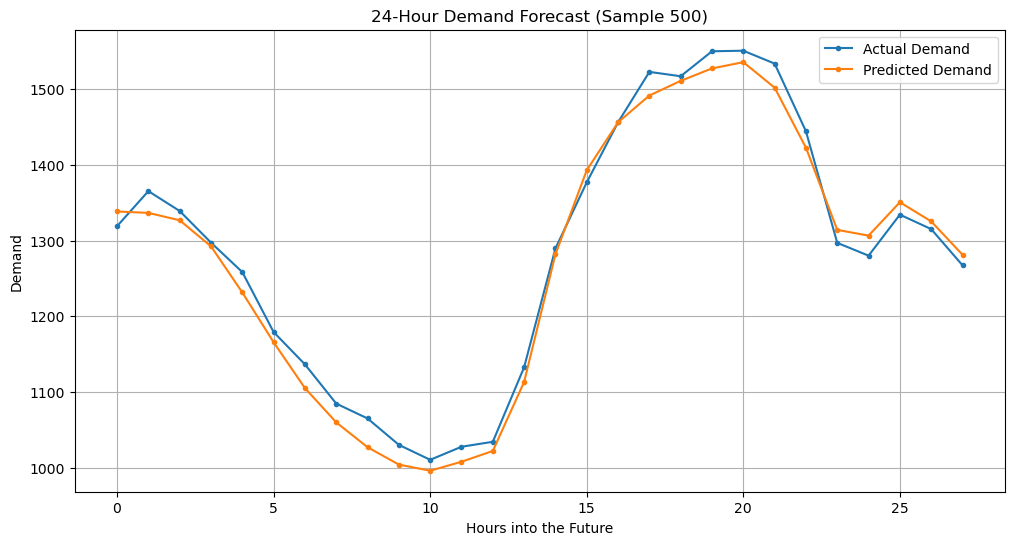

📊 MAPE = 2.27%


In [9]:
import numpy as np
import matplotlib.pyplot as plt

training_data_len = int(np.ceil(len(data) * 0.95)) 
test_data = scaled_data[training_data_len - input_len:]


X_test, Y_test_scaled = [], []
for i in range(input_len, len(test_data) - output_len):
    X_test.append(test_data[i - input_len:i])
    Y_test_scaled.append(test_data[i:i + output_len, -1])

X_test, Y_test_scaled = np.array(X_test), np.array(Y_test_scaled)

predictions_scaled = model_s2s.predict(X_test)


num_samples = X_test.shape[0]
num_features = data.shape[1] 


pred_placeholder = np.zeros((num_samples * output_len, num_features))

pred_placeholder[:, -1] = predictions_scaled.flatten()


predictions_unscaled = scaler.inverse_transform(pred_placeholder)[:, -1]


predictions_unscaled = predictions_unscaled.reshape(num_samples, output_len)


actual_placeholder = np.zeros((num_samples * output_len, num_features))
actual_placeholder[:, -1] = Y_test_scaled.flatten()
Y_test_unscaled = scaler.inverse_transform(actual_placeholder)[:, -1]
Y_test_unscaled = Y_test_unscaled.reshape(num_samples, output_len)



sample_index = 500 

plt.figure(figsize=(12, 6))
plt.plot(Y_test_unscaled[sample_index], label="Actual Demand", marker='.')
plt.plot(predictions_unscaled[sample_index], label="Predicted Demand", marker='.')
plt.title(f"24-Hour Demand Forecast (Sample {sample_index})")
plt.xlabel("Hours into the Future")
plt.ylabel("Demand")
plt.legend()
plt.grid(True)
plt.show()
mape = np.mean(np.abs((Y_test_unscaled - predictions_unscaled) / Y_test_unscaled)) * 100
print(f"📊 MAPE = {mape:.2f}%")